In [1]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

Enter channel index to analyze:5


In [2]:
source_path = '../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55'

In [3]:
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [6]:
f_names = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*CH(\d|\d\d)\.continuous$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][2:]) for f in f_names]
f_names = f_names[np.argsort(chans)] # now sorted by channel number

In [46]:
chan_data = []
for contact in range(7):
    contact_reps = []
    for i in range(contact*4, contact*4 + 4):
        print('Reading {}...'.format(f_names[i]))
        file_content = OpenEphys.load(f_names[i])
        Fs = float(file_content['header']['sampleRate'])
        signal_filtered = butter_bandpass_filter(file_content['data'], 50, 3000, Fs, order=2 )
        contact_reps.append(signal_filtered)
    contact_reps = np.array(contact_reps)
    chan_data.append(np.mean(contact_reps, axis=0))
    print('-----------------------------------------------')
chan_data = np.array(chan_data)
contact_reps = None

Reading ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/101_CH1.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/101_CH2.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/101_CH3.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/101_CH4.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/101_CH5.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/101_CH6.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/101_CH7.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/101_CH8.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/

In [47]:
common_avg_ref(chan_data)
chan_data = scipy.signal.detrend(chan_data)

chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
print('Saving filtered data to {}'.format(chan_filtered_fname))
# np.save(chan_filtered_fname, chan_data)

Saving filtered data to ../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/channels_filtered.npy


In [ ]:
chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
chan_data_raw = np.load(chan_filtered_fname)
Fs = 30000.0

### Plot channel voltage

In [ ]:
# plot channel
# plt.figure(figsize=(16,5))
# plt.plot(chan_data[chan_index, :])
# plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.shape[1]/Fs))

In [23]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)
# css.num_gmm_components = 3
css.run()
print(css.cs_indices.shape)

Pre-process time = 0.4448850154876709
Using minibatch spike detection, batch size = 50s
Spike detection time = 57.247161865234375
Align spikes time = 57.8844256401062
CS spike detection time = 77.20647978782654
CS post process time = 77.73939847946167
(1016,)


In [34]:
num_clusters = 6
pre_time = 0.0005
post_time = 0.005
clusters, cluster_labels = css.cluster_detected_cs(num_clusters=num_clusters, pre_time=pre_time, post_time=post_time)
ss_indices = css.get_ss_indices()

In [35]:
ss_indices.shape

(89785,)

In [36]:
import random
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

In [37]:
t1 = time.time()
print('Total run time = {} s'.format(t1-t0))

Total run time = 688.7697374820709 s


<IPython.core.display.Javascript object>


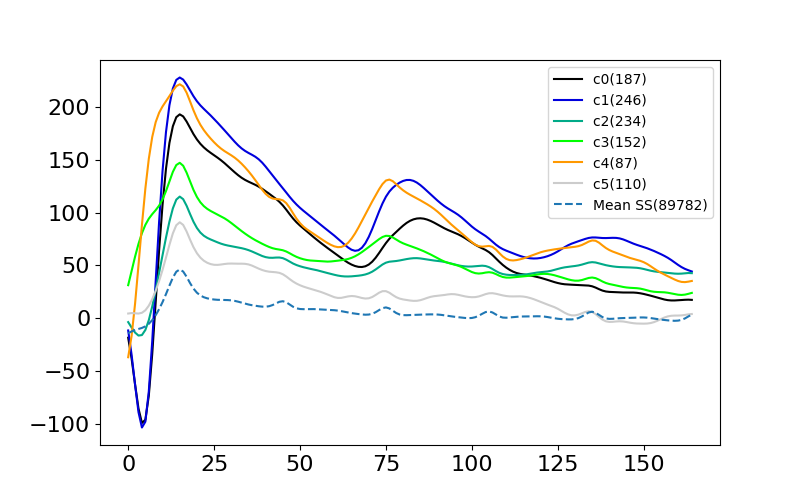

In [38]:
# plot cluster means
colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters):
    clust_means.append(np.mean(clusters[cn], axis=0))
    ax = plt.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
plt.legend() 

In [39]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(clust_means)
cs_clust = np.argmax(np.sum(np.abs(kmeans.cluster_centers_), axis=1))
clusters_to_pick = np.where(kmeans.labels_ == cs_clust)[0]
print('Detected CS clusters: {}'.format(clusters_to_pick))

Detected CS clusters: [0 1 4]


In [41]:
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]
    

Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: 0,1,3,4


In [42]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))

Number of detected CS: (672,)


## Saving detected CS and SS:

In [ ]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(chan_data_raw[chan_index,:], alpha = 0.5)
plt.plot(chan_data[chan_index,:], alpha = 0.8)
plt.eventplot(cs_indices, linelengths=300, colors='r', alpha=0.4)


In [43]:
[max_powers, powers, xf] = css._find_max_powers()
css.cs_indices=cs_indices
cs_power_ids = np.where(np.isin(css.get_spike_indices(), css.cs_indices))[0]
ss_power_ids = np.where( np.logical_not(np.isin(css.get_spike_indices(), css.cs_indices)))[0]

<IPython.core.display.Javascript object>


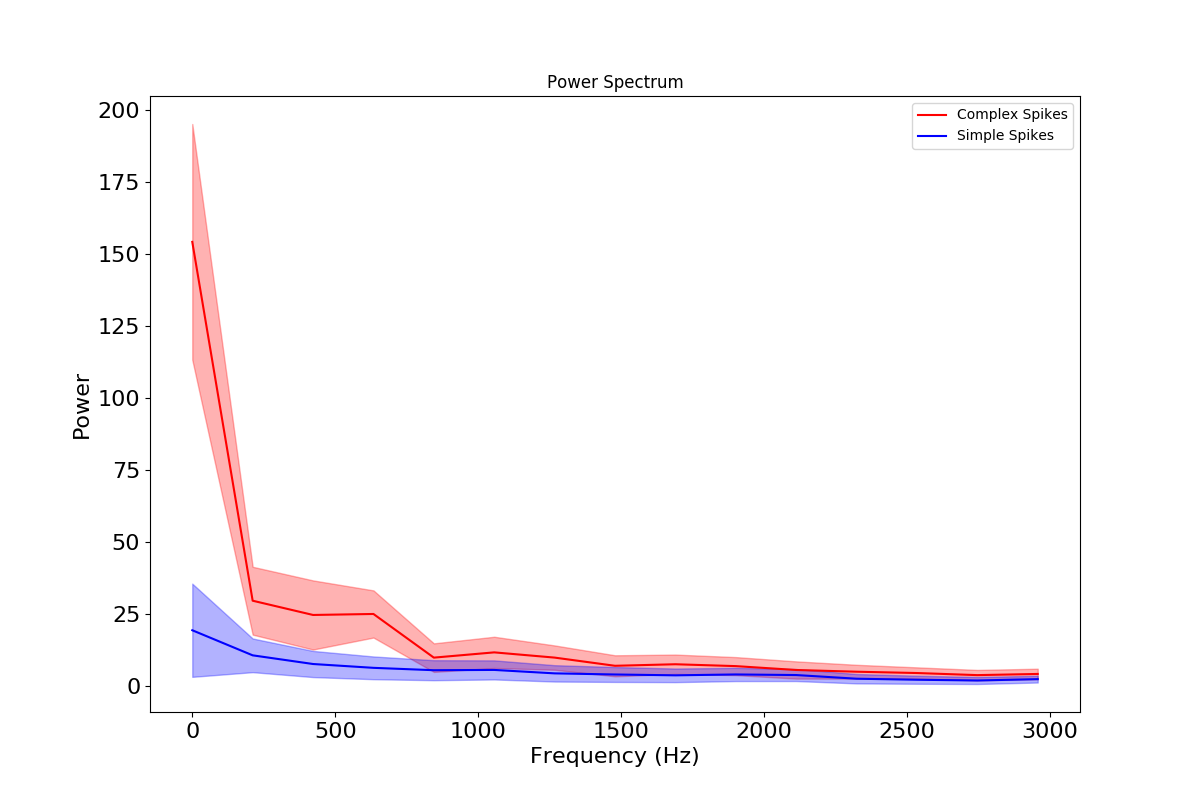

Text(0.5, 1.0, 'Power Spectrum')

In [44]:
plt.figure(figsize=(12,8))
mean_powers_cs = np.mean(powers[cs_power_ids,:], axis = 0)
se_powers_cs = np.std(powers[cs_power_ids,:], axis = 0)

mean_powers_ss = np.mean(powers[ss_power_ids,:], axis = 0)
se_powers_ss = np.std(powers[ss_power_ids,:], axis = 0)

plt.plot(xf, mean_powers_cs, 'r')
plt.fill_between(xf, mean_powers_cs - se_powers_cs, mean_powers_cs + se_powers_cs, alpha = 0.3, color = 'r')
plt.plot(xf, mean_powers_ss, 'b')
plt.fill_between(xf, mean_powers_ss - se_powers_ss, mean_powers_ss + se_powers_ss, alpha = 0.3, color = 'b')

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

plt.ylabel('Power', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.legend(['Complex Spikes', 'Simple Spikes'])
plt.title('Power Spectrum')

In [45]:
plt.savefig('../data/plots/For_cssorter_paper/Frequency_spectrum-from-0.0002-0.005-bandpass-1-3000.png', transparent=True)
plt.savefig('../data/plots/For_cssorter_paper/Frequency_spectrum-from-0.0002-0.005-bandpass-1-3000.svg', transparent=True)